-------------
### ライブラリのインポート

In [10]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------------
### 辞書作成

実験設定

In [11]:
TARGET = "GMV"
SAMPLE_SIZE = "1000"

if TARGET == "GMV":
    X_LIM_VAR = 30000
    X_LIM_REDUC = 35
if TARGET == "BCR":
    X_LIM_VAR = 0.0003
    X_LIM_REDUC = 35
if TARGET == "PM":
    X_LIM_VAR = 50
    X_LIM_REDUC = 20
if TARGET == "visit":
    X_LIM_VAR = 0.00003
    X_LIM_REDUC = 100

各ファイルからコピペ

In [12]:
var_random_train = 22835.37656992401
var_random_test = 24718.1158522326

var_sep_dict_train = {
    "Kmeans": {
        "Proportional": 20048.378425340186,
        "Post": 19430.18332810556,
        "Optimal": 18281.962661124344,
    },
    "Lasso-Kmeans": {
        "Proportional": 19436.444406538594,
        "Post": 19459.58431151917,
        "Optimal": 16844.354542512694,
    },
    "SFS-Kmeans-F": {
        "Proportional": 20687.418911635257,
        "Post": 20920.110791563064,
        "Optimal": 20166.484889983923,
    },
    "SFS-Kmeans-T": {
        "Proportional": 19275.969889421754,
        "Post": 20084.191274364995,
        "Optimal": 16882.699198509505,
    },
}
var_sep_dict_test = {
    "Kmeans": {
        "Proportional": 21841.90612981379,
        "Post": 22043.32904161241,
        "Optimal": 20019.102816074996,
    },
    "Lasso-Kmeans": {
        "Proportional": 21036.2455905483,
        "Post": 21513.15386645157,
        "Optimal": 19129.16370820761,
    },
    "SFS-Kmeans-F": {
        "Proportional": 23694.401027725624,
        "Post": 23689.886739709083,
        "Optimal": 22160.251748312374,
    },
    "SFS-Kmeans-T": {
        "Proportional": 21985.31771711119,
        "Post": 21900.565917088836,
        "Optimal": 19289.72843257505,
    },
}

var_once_dict_train = {
    "Proportional": 19801.668044173966,
    "Post": 19856.135989464266,
    "Optimal": 17007.170694701035,
}
var_once_dict_test = {
    "Proportional": 21634.97315156372,
    "Post": 21701.772041311495,
    "Optimal": 18968.696616926336,
}

var_cuped_train = 19772.612620528573
var_cuped_test = 21567.252238889858

var_coss_train = 21602.936031650497
var_coss_test = 23339.59897665968


分散削減率の計算

In [13]:
reduc_sep_dict_train = {}
reduc_sep_dict_test = {}
for method, d in var_sep_dict_train.items():
    reduc_sep_dict_train[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_train[method][allo] = (1 - var / var_random_train) * 100
for method, d in var_sep_dict_test.items():
    reduc_sep_dict_test[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_test[method][allo] = (1 - var / var_random_test) * 100

reduc_once_dict_train = {}
reduc_once_dict_test = {}
for allo, var in var_once_dict_train.items():
    reduc_once_dict_train[allo] = (1 - var / var_random_train) * 100
for allo, var in var_once_dict_test.items():
    reduc_once_dict_test[allo] = (1 - var / var_random_test) * 100

reduc_cuped_train = (1 - var_cuped_train / var_random_train) * 100
reduc_cuped_test = (1 - var_cuped_test / var_random_test) * 100

reduc_coss_train = (1 - var_coss_train / var_random_train) * 100
reduc_coss_test = (1 - var_coss_test / var_random_test) * 100

In [14]:
def make_var_dict(
    var_random: float,
    var_cuped: float,
    var_coss: float,
    var_sep_dict: dict[str, dict[str, float]],
    var_once_dict: dict[str, float],
) -> dict:
    var_dict = {"Random": var_random, "CUPED": var_cuped, "COSS": var_coss}
    for method, _ in var_sep_dict.items():
        var_dict[method] = {
            "Optimal": var_sep_dict[method]["Optimal"],
            "Proportional": var_sep_dict[method]["Proportional"],
        }
    var_dict["SFS-Kmeans-Var"] = {
        "Optimal": var_once_dict["Optimal"],
        "Proportional": var_once_dict["Proportional"],
    }

    return var_dict


def make_reduc_dict(
    reduc_cuped: float,
    reduc_coss: float,
    reduc_sep_dict: dict[str, dict[str, float]],
    reduc_once_dict: dict[str, float],
) -> dict:
    reduc_dict = {"CUPED": reduc_cuped, "COSS": reduc_coss}
    for method, _ in reduc_sep_dict.items():
        reduc_dict[method] = {
            "Optimal": reduc_sep_dict[method]["Optimal"],
            "Proportional": reduc_sep_dict[method]["Proportional"],
        }
    reduc_dict["SFS-Kmeans-Var"] = {
        "Optimal": reduc_once_dict["Optimal"],
        "Proportional": reduc_once_dict["Proportional"],
    }

    return reduc_dict

In [15]:
var_dict_train = make_var_dict(
    var_random=var_random_train,
    var_cuped=var_cuped_train,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_train,
    var_once_dict=var_once_dict_train,
)
var_dict_test = make_var_dict(
    var_random=var_random_test,
    var_cuped=var_cuped_test,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_test,
    var_once_dict=var_once_dict_test,
)

reduc_dict_train = make_reduc_dict(
    reduc_cuped=reduc_cuped_train,
    reduc_coss=reduc_coss_train,
    reduc_sep_dict=reduc_sep_dict_train,
    reduc_once_dict=reduc_once_dict_train,
)
reduc_dict_test = make_reduc_dict(
    reduc_cuped=reduc_cuped_test,
    reduc_coss=reduc_coss_test,
    reduc_sep_dict=reduc_sep_dict_test,
    reduc_once_dict=reduc_once_dict_test,
)

-----------
### 可視化

分散

訓練データの結果


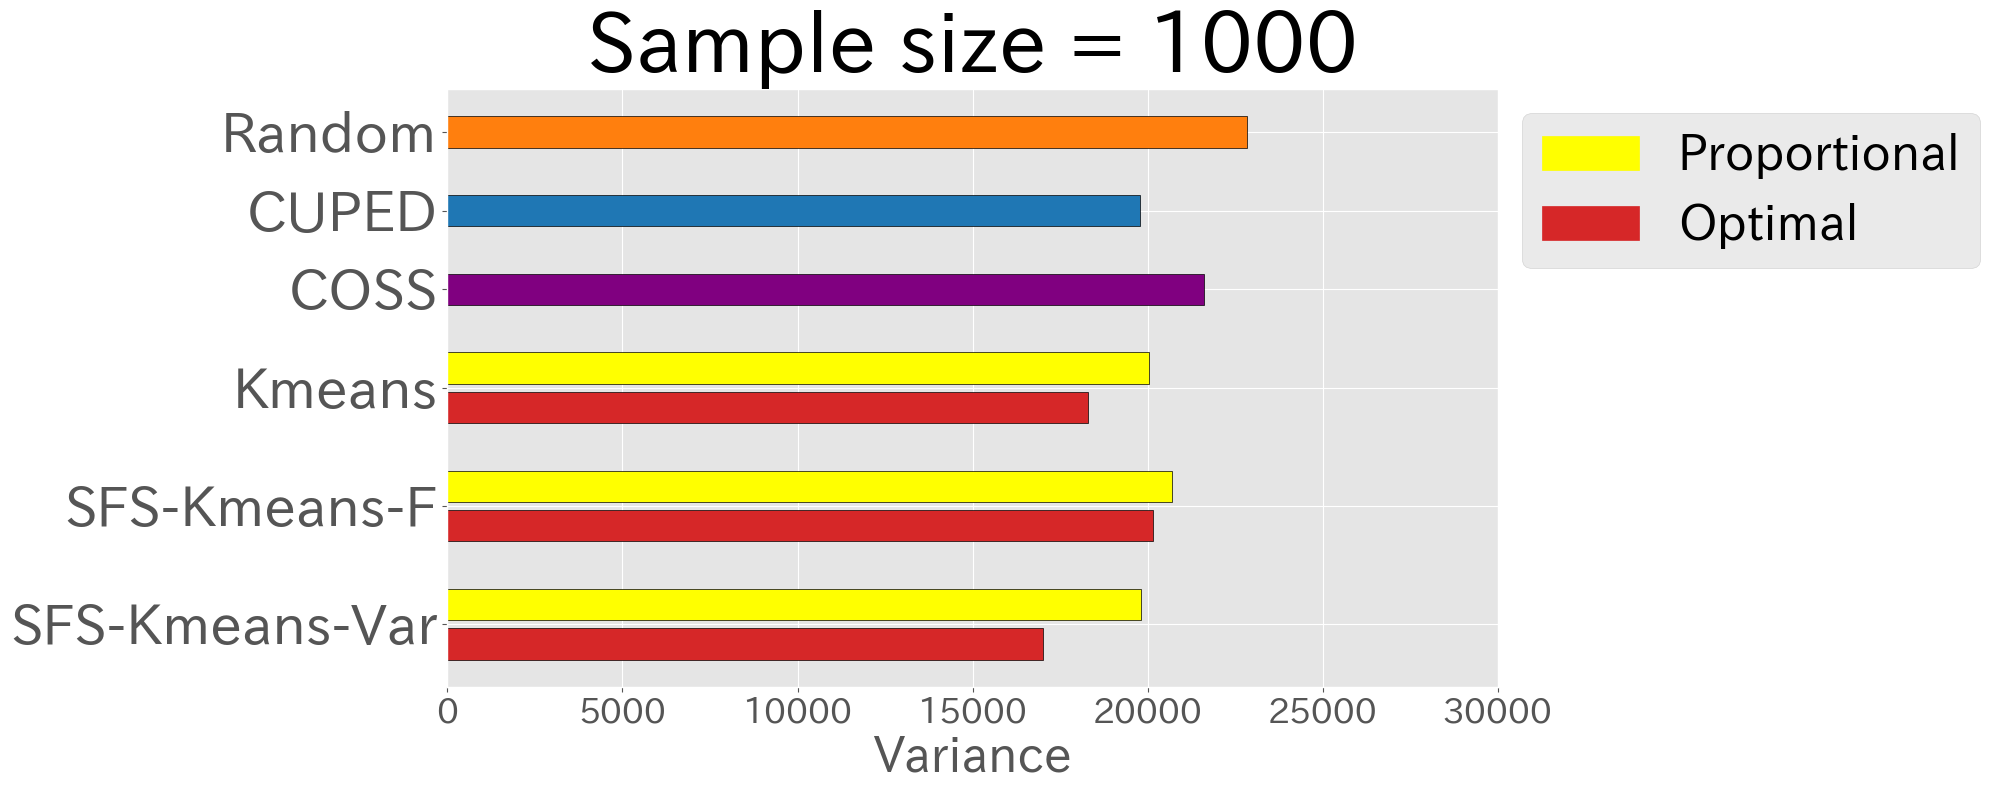

テストデータの結果


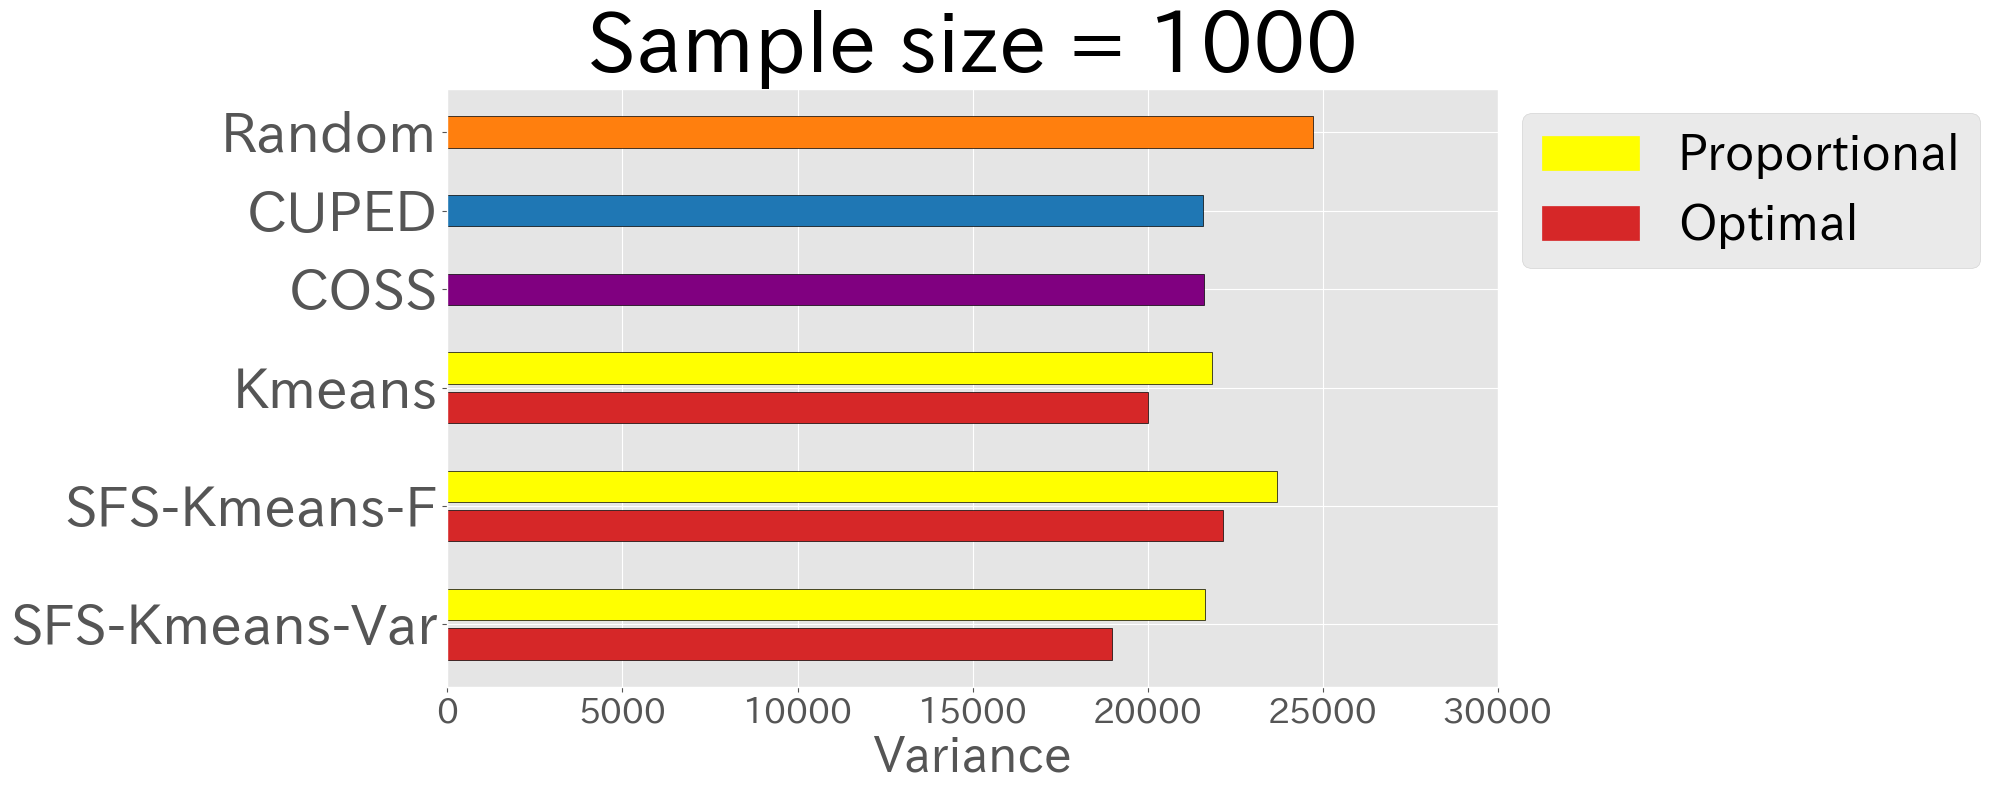

In [16]:
for var_dict in [var_dict_train, var_dict_test]:
    if var_dict == var_dict_train:
        print("訓練データの結果")
    if var_dict == var_dict_test:
        print("テストデータの結果")
    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "SFS-Kmeans-F",
        "Kmeans",
        "COSS",
        "CUPED",
        "Random",
    ]

    values = (
        list(var_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(var_dict["Kmeans"].values())
        + [0]
        + [var_dict["COSS"]]
        + [0]
        + [var_dict["CUPED"]]
        + [0]
        + [var_dict["Random"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#800080"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
        + ["#FFFFFF00"]
        + ["#ff7f0e"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [0.5, 3.5, 6.5, 9, 11, 13]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance", fontsize=35)
    ax.set_title(f"Sample size = {SAMPLE_SIZE}", fontsize=60)
    ax.set_xlim(0, X_LIM_VAR)
    plt.tight_layout()
    plt.show()

削減率

訓練データの結果


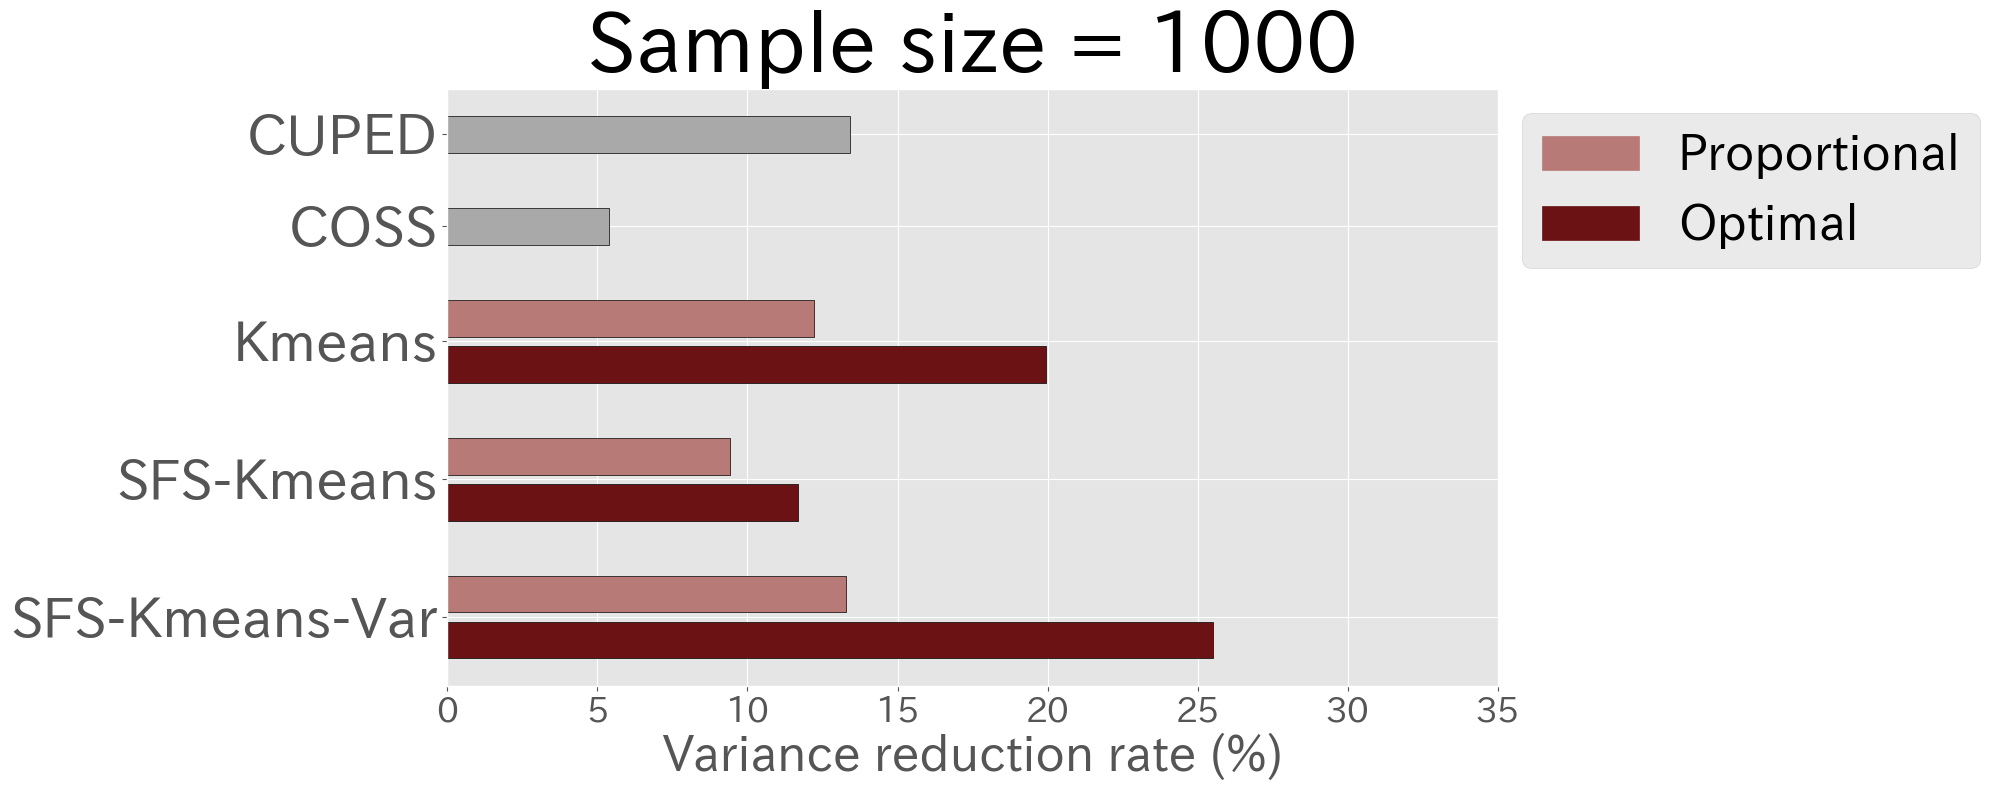

テストデータの結果


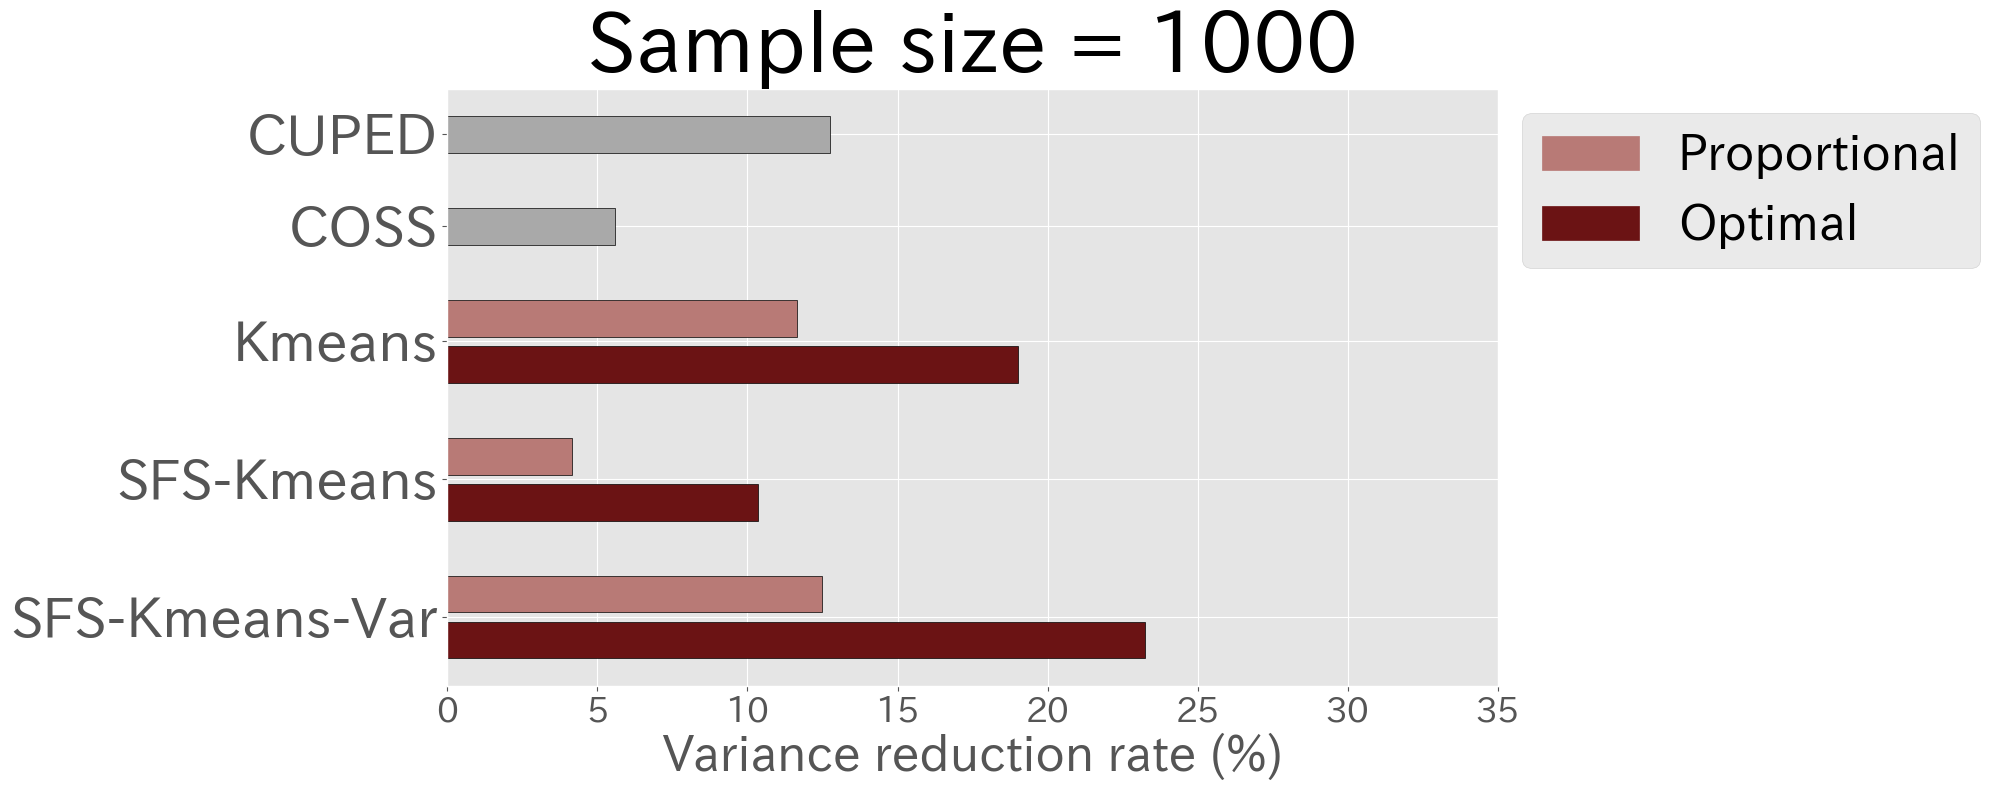

In [17]:
for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "SFS-Kmeans",
        "Kmeans",
        "COSS",
        "CUPED",
    ]
    values = (
        list(reduc_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + [reduc_dict["COSS"]]
        + [0]
        + [reduc_dict["CUPED"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#6b1314", "#b87a76"]
        + ["#FFFFFF00"]
        + ["#6b1314", "#b87a76"]
        + ["#FFFFFF00"]
        + ["#6b1314", "#b87a76"]
        + ["#FFFFFF00"]
        + ["#a9a9a9"]
        + ["#FFFFFF00"]
        + ["#a9a9a9"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [0.5, 3.5, 6.5, 9, 11]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Optimal"]
    # 色のリスト
    legend_colors = ["#b87a76", "#6b1314"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance reduction rate (%)", fontsize=35)
    ax.set_title(f"Sample size = {SAMPLE_SIZE}", fontsize=60)
    ax.set_xlim(0, X_LIM_REDUC)
    plt.tight_layout()
    plt.show()

訓練データの結果


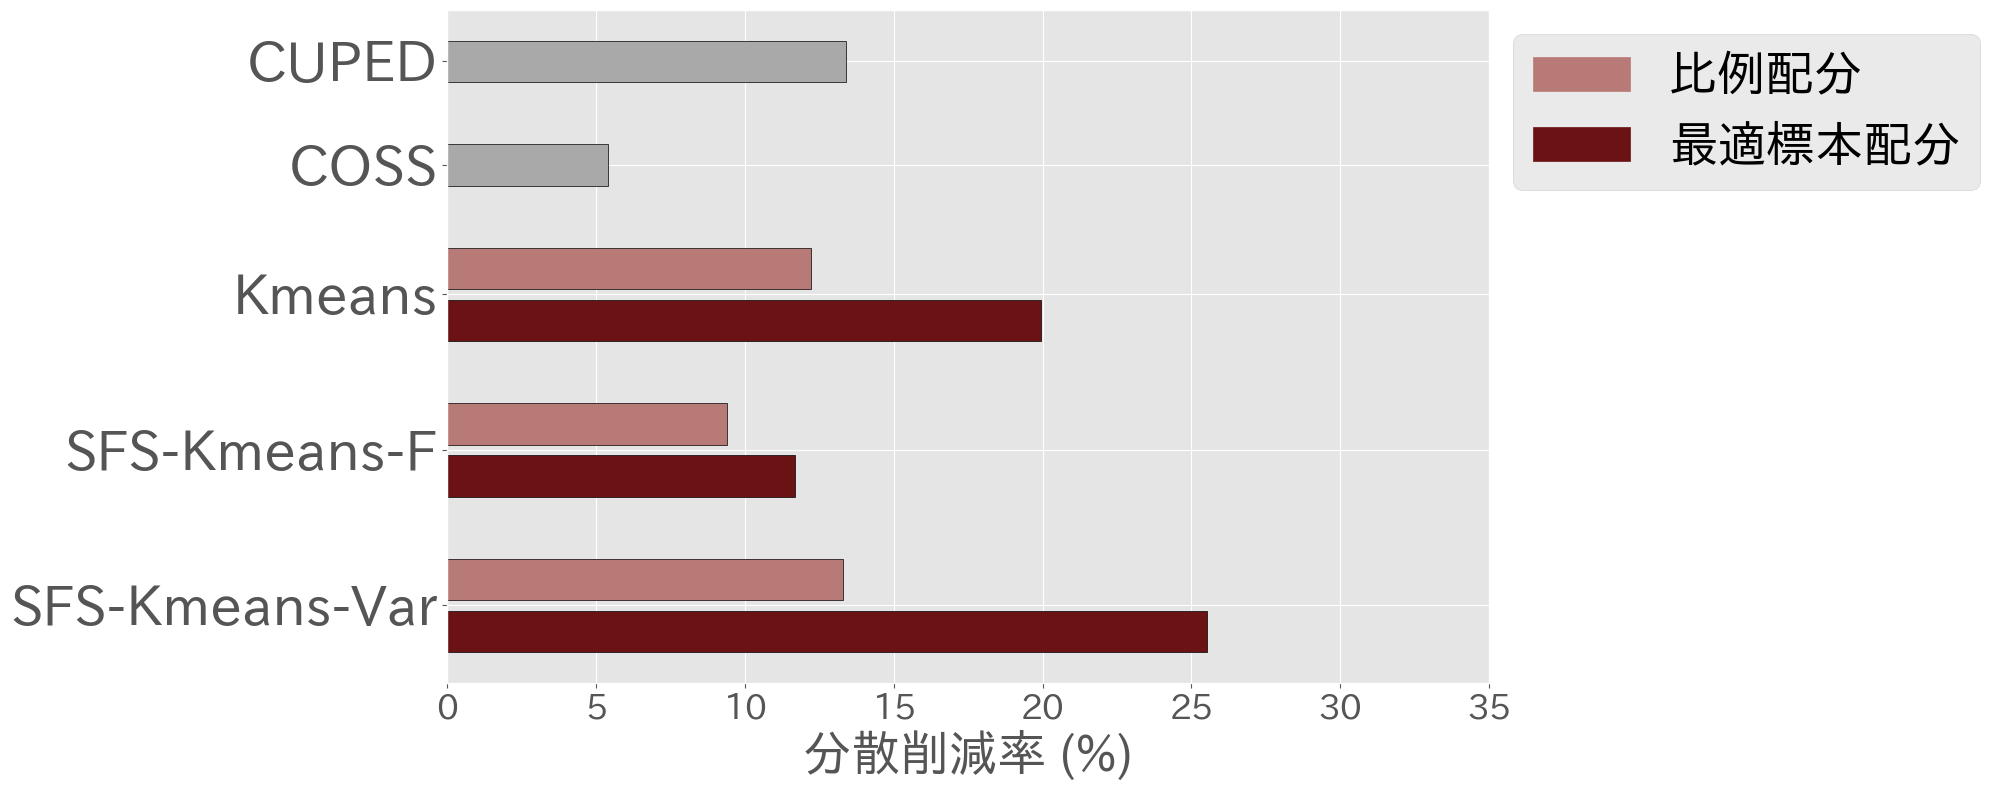

テストデータの結果


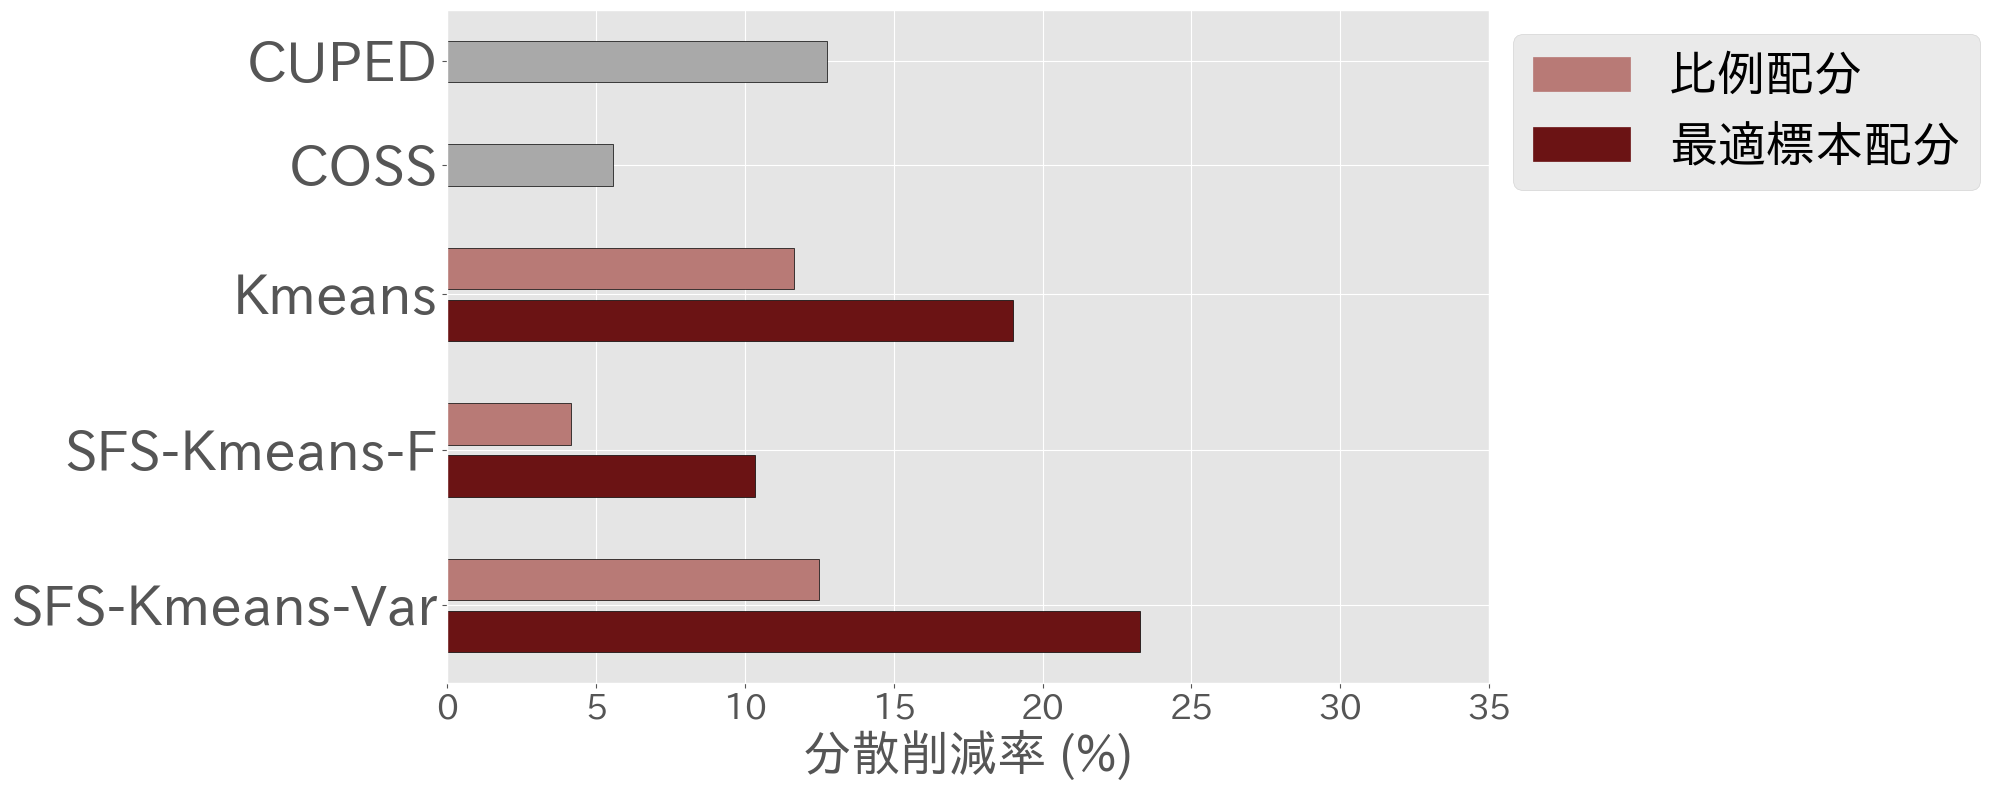

In [18]:
for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "SFS-Kmeans-F",
        "Kmeans",
        "COSS",
        "CUPED",
    ]
    values = (
        list(reduc_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + [reduc_dict["COSS"]]
        + [0]
        + [reduc_dict["CUPED"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#6b1314", "#b87a76"]
        + ["#FFFFFF00"]
        + ["#6b1314", "#b87a76"]
        + ["#FFFFFF00"]
        + ["#6b1314", "#b87a76"]
        + ["#FFFFFF00"]
        + ["#a9a9a9"]
        + ["#FFFFFF00"]
        + ["#a9a9a9"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [0.5, 3.5, 6.5, 9, 11]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["比例配分", "最適標本配分"]
    # 色のリスト
    legend_colors = ["#b87a76", "#6b1314"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("分散削減率 (%)", fontsize=35)
    # ax.set_title(f"標本サイズ：{SAMPLE_SIZE}", fontsize=60)
    ax.set_xlim(0, X_LIM_REDUC)
    plt.tight_layout()
    plt.show()

### 箱ひげ図